# CLIP

- Code | https://github.com/RustamyF/clip-multimodal-ml 
- Blog | [CLIP Model and The Importance of Multimodal Embeddings](https://towardsdatascience.com/clip-model-and-the-importance-of-multimodal-embeddings-1c8f6b13bf72#:~:text=The%20CLIP%20loss%20aims%20to,the%20N%C2%B2%20%E2%88%92%20N%20incorrect%20pairings.)

这篇博文写的特别详细，在loss部分的实现贴近论文，在原论文没有公开训练代码的情况下，很值得学习。

In [3]:
import torch
import os
import subprocess
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from transformers import AutoModel, AutoTokenizer, BertTokenizer

import json
from PIL import Image
from torch.utils.data import Dataset
import collections
from torchvision import transforms
from datasets import load_dataset
from dataclasses import dataclass
import numpy as np
import pandas as pd
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import sys

In [4]:
print("Python版本信息:")
print(sys.version)

print("torch版本信息:")
print(torch.__version__)

print("python路径:")
print(sys.executable)

Python版本信息:
3.10.6 (main, Oct 24 2022, 16:07:47) [GCC 11.2.0]
torch版本信息:
1.13.1+cu117
python路径:
/opt/anaconda3/envs/sd-webui/bin/python


In [5]:
@dataclass
class Config:
    """
    Configuration class for the CLIP training script.
    """

    embed_dim: int = 512  # Embedding dimension
    transformer_embed_dim: int = 768  # Transformer embedding dimension
    max_len: int = 32  # Maximum text length
    text_model: str = "distilbert-base-multilingual-cased"  # Text model name
    epochs: int = 5  # Number of training epochs
    batch_size: int = 128  # Batch size
    image_path = "./dataset/flickr8k/Images/"
    captions_path = "./dataset/flickr8k/"

In [6]:

class Flickr8kDataset(torch.utils.data.Dataset):
    def __init__(self):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """
        
        self.image_filenames, self.captions = self.load_data()
        
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        item = {}
      
        img_path = f"{Config.image_path}/{self.image_filenames[idx]}"
        img = Image.open(img_path)
        
        item['image'] = self.transform(img)
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)
    
    def load_data(self):
        dataframe = pd.read_csv(f"{Config.captions_path}/captions1000.csv")
        max_id = dataframe["id"].max() + 1
        image_ids = np.arange(0, max_id)
        np.random.seed(42)
        valid_ids = np.random.choice(
            image_ids, size=int(0.2 * len(image_ids)), replace=False
        )
        train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
        train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
        
        # valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    
        return train_dataframe["image"].values, list(train_dataframe["caption"].values)

# Create an instance of the custom dataset
flickr30k_custom_dataset = Flickr8kDataset()


In [7]:
# Create the DataLoader
clip_dataloader = DataLoader(flickr30k_custom_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=4)


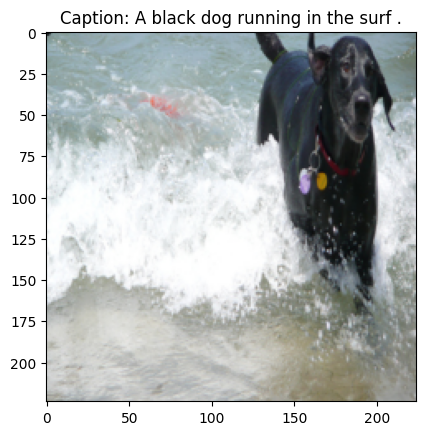

In [8]:
import numpy as np
import matplotlib.pyplot as plt
# Create an iterator from the dataloader
data_iter = iter(clip_dataloader)

# Get one batch
batch = next(data_iter)


image = batch["image"][0]  # Assuming batch size is greater than 0
caption = batch["caption"][0]

# Convert the image tensor to a NumPy array and permute dimensions
image_np = np.transpose(image.numpy(), (1, 2, 0))

# Display the image and caption
plt.imshow(image_np)
plt.title(f"Caption: {caption}")
plt.show()

In [9]:
print("example of a caption in abatch:",  batch["caption"][0])
print("number of captions in each batch:",len(batch["caption"]))

example of a caption in abatch: A black dog running in the surf .
number of captions in each batch: 128


In [10]:
# !pip install git+https://github.com/openai/CLIP.git --quiet

In [11]:
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

def CLIP_loss(logits: torch.Tensor) -> torch.Tensor:
    # Assuming n is the number of classes
    n = logits.shape[1]

    # Create labels tensor
    labels = torch.arange(n).to(device)

    # Calculate cross entropy losses along axis 0 and 1
    loss_i = F.cross_entropy(logits.transpose(0, 1), labels, reduction="mean")
    loss_t = F.cross_entropy(logits, labels, reduction="mean")

    # Calculate the final loss
    loss = (loss_i + loss_t) / 2

    return loss

def metrics(similarity: torch.Tensor):
    y = torch.arange(len(similarity)).to(similarity.device)
    img2cap_match_idx = similarity.argmax(dim=1)
    cap2img_match_idx = similarity.argmax(dim=0)

    img_acc = (img2cap_match_idx == y).float().mean()
    cap_acc = (cap2img_match_idx == y).float().mean()

    return img_acc, cap_acc

In [12]:
# import clip
# model, preprocess = clip.load("ViT-B/32", device=device)

# image = batch["image"].to(device)
# true_text = batch["caption"]
# wrong_text = true_text[::-1]


# for captions in [true_text, wrong_text]:
#     text = clip.tokenize(captions).to(device)

#     # with torch.no_grad():
#     image_features = model.encode_image(image)
#     text_features = model.encode_text(text)

#     # normalized features
#     image_features = image_features / image_features.norm(dim=1, keepdim=True)
#     text_features = text_features / text_features.norm(dim=1, keepdim=True)
#     similarity = text_features @ image_features.T
#     loss = CLIP_loss(similarity)
#     print(loss)

In [13]:
from transformers import AutoModel, AutoTokenizer, BertTokenizer
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Projection(nn.Module):
    def __init__(self, d_in: int, d_out: int, p: float = 0.5) -> None:
        super().__init__()
        self.linear1 = nn.Linear(d_in, d_out, bias=False)
        self.linear2 = nn.Linear(d_out, d_out, bias=False)
        self.layer_norm = nn.LayerNorm(d_out)
        self.drop = nn.Dropout(p)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        embed1 = self.linear1(x)
        embed2 = self.drop(self.linear2(F.gelu(embed1)))
        embeds = self.layer_norm(embed1 + embed2)
        return embeds


class VisionEncoder(nn.Module):
    def __init__(self, d_out: int) -> None:
        super().__init__()
        base = models.resnet34(pretrained=True)
        d_in = base.fc.in_features
        base.fc = nn.Identity()
        self.base = base
        self.projection = Projection(d_in, d_out)
        for p in self.base.parameters():
            p.requires_grad = False

    def forward(self, x):
        projected_vec = self.projection(self.base(x))
        projection_len = torch.norm(projected_vec, dim=-1, keepdim=True)
        return projected_vec / projection_len


class TextEncoder(nn.Module):
    def __init__(self, d_out: int) -> None:
        super().__init__()
        self.base = AutoModel.from_pretrained(Config.text_model)
        self.projection = Projection(Config.transformer_embed_dim, d_out)
        for p in self.base.parameters():
            p.requires_grad = False

    def forward(self, x):
        out = self.base(x)[0]
        out = out[:, 0, :]  # get CLS token output
        projected_vec = self.projection(out)
        projection_len = torch.norm(projected_vec, dim=-1, keepdim=True)
        return projected_vec / projection_len


In [14]:
class Tokenizer:
    def __init__(self, tokenizer: BertTokenizer) -> None:
        self.tokenizer = tokenizer

    def __call__(self, x: str) -> AutoTokenizer:
        return self.tokenizer(
            x, max_length=Config.max_len, truncation=True, padding=True, return_tensors="pt"
        )


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
image = batch["image"].to(device)
true_text = batch["caption"]
wrong_text = true_text[::-1]

vision_encoder = VisionEncoder(Config.embed_dim).to(device)
caption_encoder = TextEncoder(Config.embed_dim).to(device)
tokenizer = Tokenizer(AutoTokenizer.from_pretrained(Config.text_model))

for captions in [true_text, wrong_text]:
    text = tokenizer(captions).to(device)

    # with torch.no_grad():
    image_features = vision_encoder(image)
    text_features = caption_encoder(text["input_ids"])

    # normalized features
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    similarity = text_features @ image_features.T
    loss = CLIP_loss(similarity)
    print(loss)

/opt/anaconda3/envs/sd-webui/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/sd-webui/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model 

tensor(4.8498, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.8532, device='cuda:0', grad_fn=<DivBackward0>)


In [16]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from typing import List, Tuple


class CustomModel(nn.Module):
    def __init__(self, lr: float = 1e-3) -> None:
        super().__init__()
        self.vision_encoder = VisionEncoder(Config.embed_dim)
        self.caption_encoder = TextEncoder(Config.embed_dim)
        self.tokenizer = Tokenizer(AutoTokenizer.from_pretrained(Config.text_model, use_fast=False))
        self.lr = lr
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def forward(self, images, text):
        text = self.tokenizer(text).to(self.device)

        image_embed = self.vision_encoder(images)
        caption_embed = self.caption_encoder(text["input_ids"])
        similarity = caption_embed @ image_embed.T

        loss = CLIP_loss(similarity)
        img_acc, cap_acc = metrics(similarity)
        return loss, img_acc, cap_acc



In [17]:
# Create an instance of your model
model = CustomModel().to(device)

/opt/anaconda3/envs/sd-webui/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/sd-webui/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model 

In [18]:
# Define optimizer
optimizer = torch.optim.Adam([
    {'params': model.vision_encoder.parameters()},
    {'params': model.caption_encoder.parameters()}
], lr=model.lr)


In [19]:
start_epoch = 0
num_epochs = 3

batch_zero = True
for epoch in range(start_epoch, num_epochs):
    model.train()
    for batch in clip_dataloader:
        image = batch["image"].to(device)
        text = batch["caption"]
        # images, text = batch
        loss, img_acc, cap_acc = model(image, text)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_zero:
          print(f"Epoch [{0}/{num_epochs}], Batch Loss: {loss.item()}")
          batch_zero = False


    # Print training statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], Batch Loss: {loss.item()}")

print("Training complete.")

Epoch [0/3], Batch Loss: 4.852458477020264
Epoch [1/3], Batch Loss: 3.3917770385742188
Epoch [2/3], Batch Loss: 3.326610565185547
Epoch [3/3], Batch Loss: 3.1715004444122314
Training complete.
